# Mapping new data to the Human Lung Cell Atlas

In this notebook, we will guide you through how to map your data to the Human Lung Cell Atlas (core reference), perform label transfer, and more. For that purpose we use scArches, a method to map new single cell/single nucleus data to an existing reference (see also Lotfollahi et al., Nature Biotechnology 2021 https://doi.org/10.1038/s41587-021-01001-7). 

Start by setting the directory that has the needed files (model, cell type names, reference embedding etc.) as downloaded from Zenodo @LISA ADD LINK!:

In [90]:
HLCA_folder="../HLCA_scArches"

Import the needed modules. __Note that we use scArches version 0.3.5.__ For efficiency of knn-graph and umap calculation, we recommend using scanpy>=1.8.2, umap-learn>0.5, and installing pynndescent: `pip install pynndescent`.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scarches as sca

import scarches-based label transfer script:

In [92]:
import sys
sys.path.append(HLCA_folder)
import scarches_label_transfer

Set figure parameters (change for bigger/smaller plots):

In [4]:
sc.set_figure_params(figsize=(5,5))

We'll print versions of the imported modules here, for reproducibility purposes:

In [5]:
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                         8.1.0
anndata                     0.7.5
anyio                       NA
attr                        20.3.0
babel                       2.9.0
backcall                    0.2.0
certifi                     2020.12.05
cffi                        1.14.4
chardet                     4.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.1
decorator                   4.4.2
h5py                        2.10.0
idna                        2.10
ipykernel                   5.4.3
ipython_genutils            0.2.0
ipywidgets                  8.0.0a0
jedi                        0.18.0
jinja2                      2.11.3
joblib                      1.0.0
json5                       NA
jsonschema                  3.2.0
jupyter_server              1.4.1
jupyterlab_server           2.3.0
kiwisolver                  1.3.1
llvmlite     

## import information about reference:

These files can be downloaded from Zenodo (see beginning of notebook)

In [7]:
# gene order for scArches model
reference_gene_order = pd.read_csv(f"{HLCA_folder}/HLCA_scarches_gene_order.csv")
# reference embedding, including cell/sample/subject metadata:
reference_embedding = sc.read_h5ad(f"{HLCA_folder}/HLCA_emb_and_metadata.h5ad")
# path to scArches reference model
reference_model_path = HLCA_folder

## import your data:

IMPORTANT:  
1. Make sure you have only and all the genes from the reference_gene_order, and make sure that your genes are in the same order as the genes in that dataframe (we also check this below). This is essential for the mapping to work. Set missing genes to zero.  
2. Make sure that you have raw (i.e. un-normalized, integer) counts in your data (.X layer).

Here we use an example dataset, from the Delorey et al. preprint:  https://www.biorxiv.org/content/10.1101/2021.02.25.430130v1. We only use the fresh, single-cell sample from this dataset. 

In [8]:
query_data = sc.read_h5ad(f"{HLCA_folder}/test_dataset_Regev_2021_Fresh.h5ad")

check gene order:

In [9]:
if (query_data.var.index == reference_gene_order.gene_symbol).all() or (
    query_data.var.index == reference_gene_order.gene_id
).all():
    print("Gene order is correct.")
else:
    print(
        "WARNING: your gene order does not match the order of the HLCA reference. Fix this before continuing!"
    )

Gene order is correct.


# Prepare query data for mapping: 

Make sure that you have raw data in query_data.X. We will now copy that information to query_data.raw for scArches.

In [10]:
query_data.raw = query_data
raw = query_data.raw.to_adata()
raw.X = query_data.X
query_data.raw = raw

quick check if X and raw.X have integers (do a more systematic check if you have any doubts!):

In [11]:
query_data.raw.X[:10, :10].toarray()

array([[ 0.,  9.,  1.,  0., 79.,  0.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 50.,  0.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., 68.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 21.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.,  0.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., 17.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0., 19.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)

In [12]:
query_data.X[:10, :10].toarray()

array([[ 0.,  9.,  1.,  0., 79.,  0.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 50.,  0.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., 68.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 21.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.,  0.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., 17.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0., 19.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)

Set query_data.obs["scanvi_label"] to "unlabeled". Keep this code as is, it has to do with the way the reference model was changed. 

In [13]:
query_data.obs["scanvi_label"] = "unlabeled"

### Perform surgery on reference model and train on query dataset without cell type labels

### Set scArches parameters:

Store the set of batches from your query data. This might just be a single batch.  
In the extended HLCA, we have treated datasets as batches. If you expect large batch effects between subsets of your data, it is better to spit your dataset into multiple datasets. For example, if you have data that is a mixture of 5' and 3' data, it would be better to consider those separate batches.

In [14]:
batch_variable = "dataset"  # the column name under which you stored your batch variable
query_batches = sorted(query_data.obs[batch_variable].unique())
print(query_batches)

['Regev_2021_Fresh']


These are the parameter settings we used for the extended HLCA, as recommended by the scArches developers:

In [15]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

set the output directory. The output model will be stored here, under the name of the batch. It will over-write any existing model with the same name!

In [16]:
output_dir = f"{HLCA_folder}/testout"

Now perform scArches "surgery". The result will be stored in the output dir specified above. Each dataset/batch has its own "adapter" that will be trained separately, and will be stored in the output_dir under a folder named after the batch.  
Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [17]:
for batch in query_batches: # this loop is only necessary if you have multiple batches, but will also work for a single batch.
    print("Batch:", batch)
    query_subadata = query_data[query_data.obs[batch_variable] == batch,:].copy()
    print("Shape:", query_subadata.shape)
    # load model and set relevant variables:
    model = sca.models.SCANVI.load_query_data(
        query_subadata,
        reference_model_path,
        freeze_dropout = True,
    )
    model._unlabeled_indices = np.arange(query_subadata.n_obs)
    model._labeled_indices = []
    # now train surgery model using reference model and target adata
    model.train(
        n_epochs_semisupervised=surgery_epochs,
        train_base_model=False,
        semisupervised_trainer_kwargs=dict(
            metrics_to_monitor=["accuracy", "elbo"], 
            weight_decay=0,
            early_stopping_kwargs=early_stopping_kwargs_surgery
        ),
        frequency=1
    )
    surgery_path = f"{output_dir}/{batch}"
    if not os.path.exists(surgery_path):
        os.makedirs(surgery_path)
    model.save(surgery_path, overwrite=True)

Batch: Regev_2021_Fresh
Shape: (2268, 2000)
WARNING  var_names for adata passed in does not match var_names of adata used to train the   
         model. For valid results, the vars need to be the same and in the same order as the 
         adata used to train the model.                                                      
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2268 cells, 2000 vars, 15 batches,
         29 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Trainin

to reload specific models, use the following code (not necessary if you run this script in one go)

In [ ]:
# surgery_path = f"{output_dir}/{batch}"
# model = sca.models.SCANVI.load_query_data(query_data, 'surgery_model', freeze_dropout=True) # this is before training

In [ ]:
# surgery_path = f"{output_dir}/{batch}"
# model = sca.models.SCANVI.load(surgery_path,query_data) # if already trained

### Get the latent representation of your query dataset

Here we will calculate the "latent representation", or "low-dimensional embedding" of your dataset. This embedding is in the same space as the HLCA embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.! 

Create an empty dataframe to store the embeddings of all batches:

In [18]:
emb_df = pd.DataFrame(index=query_data.obs.index,columns=range(0,reference_embedding.shape[1]))

Calculate embeddings, using the trained scArches model:

In [19]:
for batch in query_batches: # from small to large datasets
    print(f"Working on {batch}...")
    query_subadata = query_data[query_data.obs[batch_variable] == batch,:].copy()
    surgery_path = f"{output_dir}/{batch}"
    model = sca.models.SCANVI.load(surgery_path, query_subadata)
    query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
    # copy over .obs
    query_subadata_latent.obs = query_data.obs.loc[query_subadata.obs.index,:]
    query_subadata_latent.write(f"{output_dir}/{batch}/emb.h5ad")
    emb_df.loc[query_subadata.obs.index,:] = query_subadata_latent.X

Working on Regev_2021_Fresh...
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2268 cells, 2000 vars, 15 batches,
         29 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


... storing 'scanvi_label' as categorical


Convert final embedding (of all your query batches) to an anndata object:

In [20]:
query_embedding = sc.AnnData(X=emb_df.values, obs=query_data.obs)

## Combine the embedding of the HLCA and the query data

Add query vs. reference information:

In [21]:
query_embedding.obs['HLCA_or_query'] = "query"
reference_embedding.obs['HLCA_or_query'] = "HLCA"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. "_" and batch_key to the obs column that you want to use as barcode suffix (e.g. "dataset").

In [22]:
# concatenate source and target data
combined_emb = reference_embedding.concatenate(query_embedding, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

## Downstream analysis: plotting and label transfer

#### umap plotting:

We can now do joint downstream analysis, such as clustering, UMAP embedding, label transfer etc. 

Note that the knngraph + umap calculation can take quite a while. See notes at the top of this notebook for speeding up the process.

In [47]:
sc.pp.neighbors(combined_emb, n_neighbors=30)

In [48]:
sc.tl.umap(combined_emb)

Now we can start plotting umaps, here is just one example:

... storing 'sample' as categorical
... storing 'study_long' as categorical
... storing 'study' as categorical
... storing 'last_author_PI' as categorical
... storing 'subject_ID' as categorical
... storing 'sex' as categorical
... storing 'ethnicity' as categorical
... storing 'mixed_ethnicity' as categorical
... storing 'smoking_status' as categorical
... storing 'condition' as categorical
... storing 'subject_type' as categorical
... storing 'sample_type' as categorical
... storing 'single_cell_platform' as categorical
... storing "3'_or_5'" as categorical
... storing 'sequencing_platform' as categorical
... storing 'cell_ranger_version' as categorical
... storing 'fresh_or_frozen' as categorical
... storing 'dataset' as categorical
... storing 'anatomical_region_level_1' as categorical
... storing 'anatomical_region_level_2' as categorical
... storing 'anatomical_region_level_3' as categorical
... storing 'original_ann_level_1' as categorical
... storing 'original_ann_level_2' as c

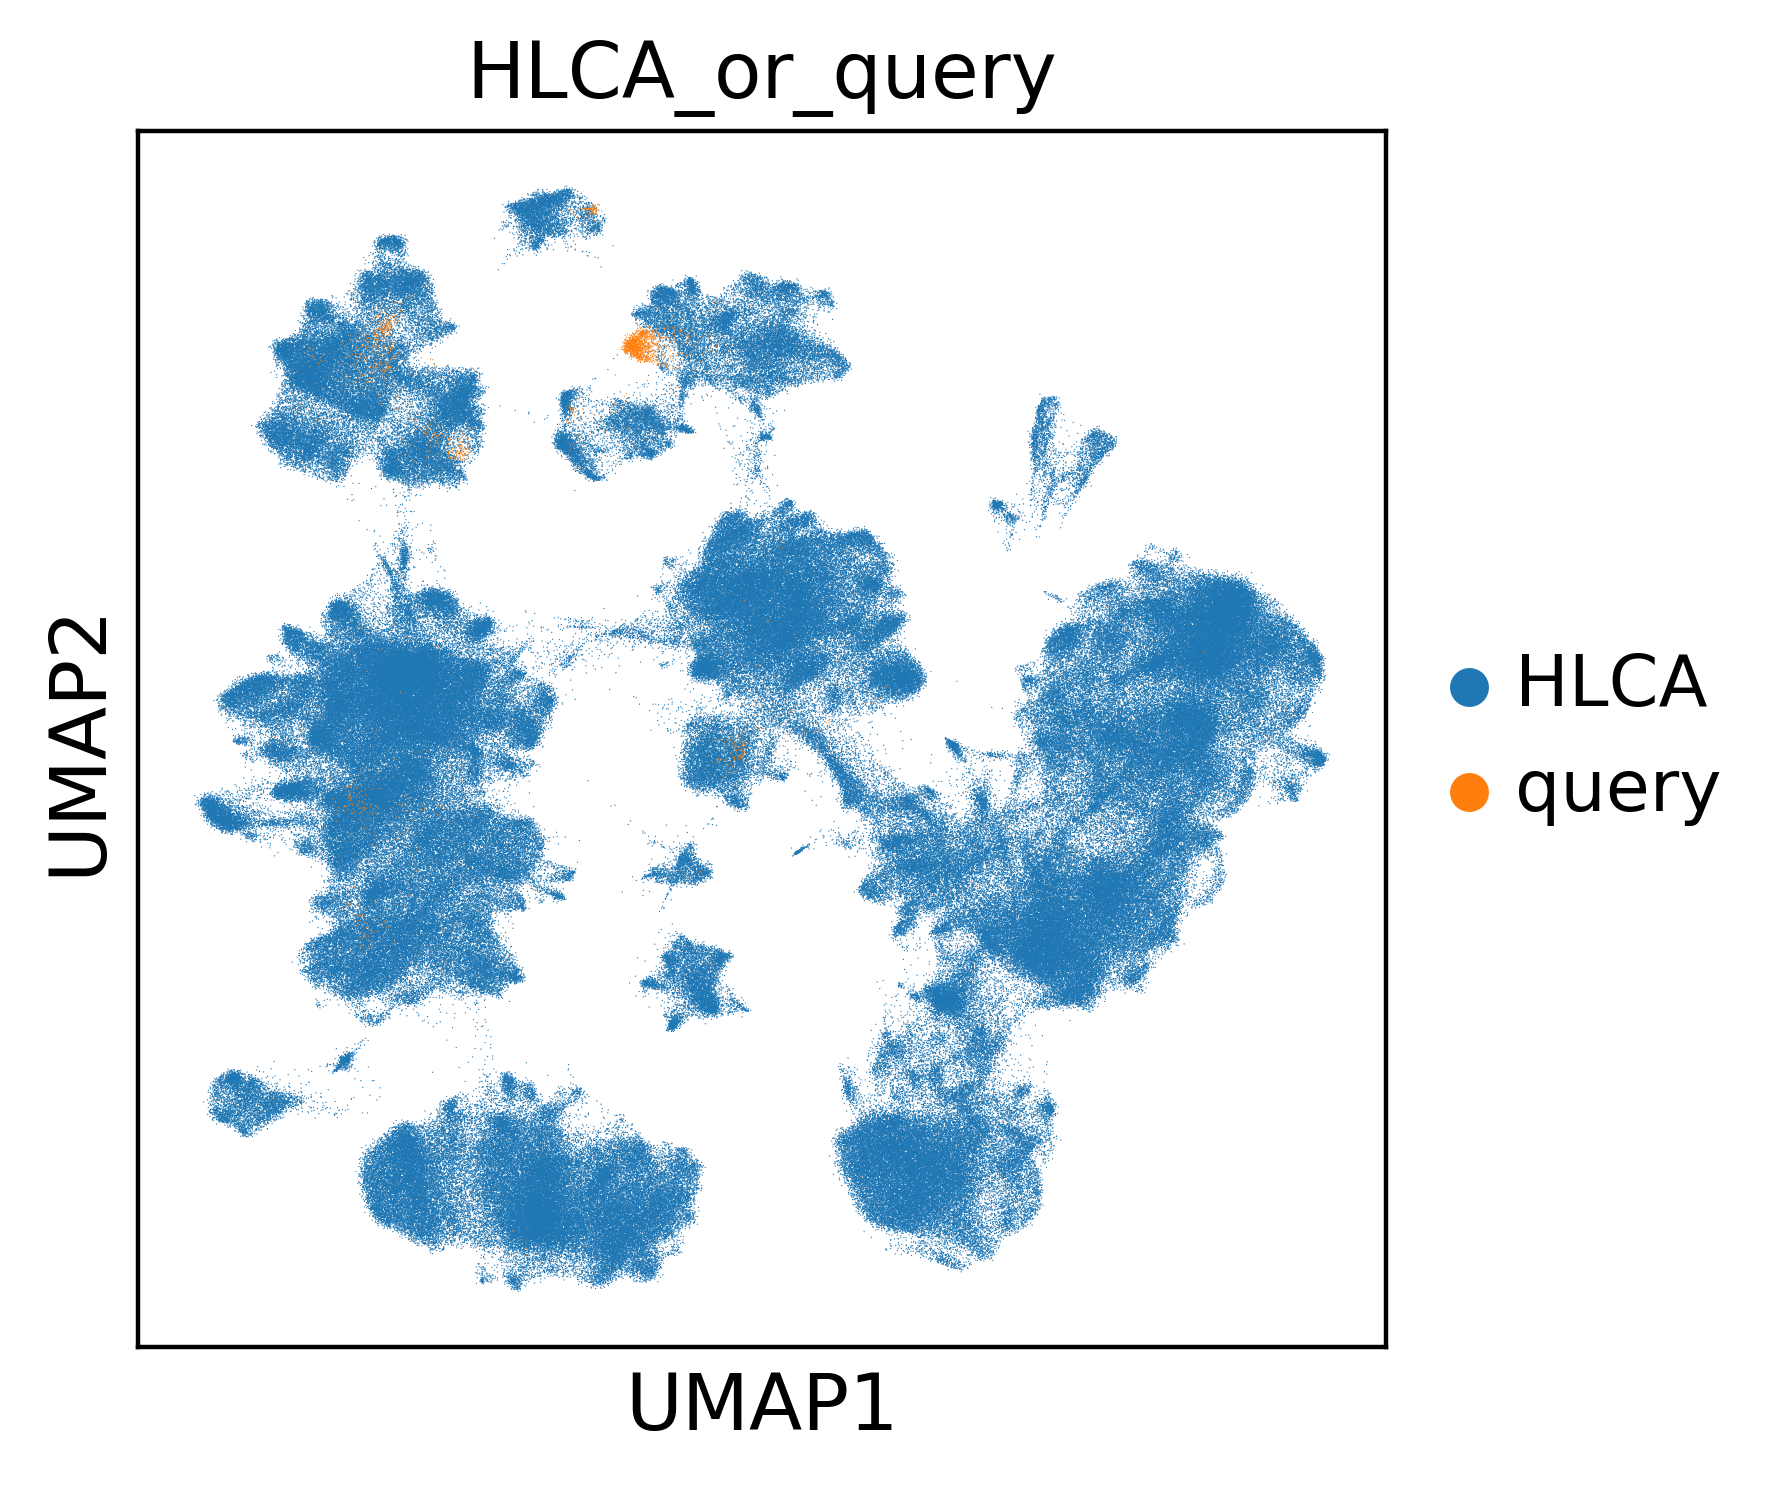

In [49]:
sc.pl.umap(combined_emb, color="HLCA_or_query")

Store result, if wanted:

In [52]:
combined_emb.write(f"{output_dir}/combined_embedding.h5ad")

Any other graph-based or latent-space based downstream method can also be used, based on the embedding and the above-calculated graph. We will proceed to label transfer here.

## Label transfer:

Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5).  
Note that some cell types don't have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we "propagate" to the higher levels, i.e. you will see "3_Mast cells" in level 4 and 5 annotations. (Most cell types don't have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

Import the set of finest cell type labels, and their matching lower-level annotations (cell types are also ordered in a biologically sensible order in this table, you can use this order for downstream plotting etc. if wanted):

In [89]:
cts_ordered = pd.read_csv(f"{HLCA_folder}/HLCA_celltypes_ordered.csv",index_col=0)    

Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

In [25]:
# run k-neighbors transformer
k_neighbors_transformer = scarches_label_transfer.weighted_knn_trainer(
    train_adata=reference_embedding,
    train_adata_emb="X", # location of our joint embedding
    n_neighbors=50,
    )    
# perform label transfer
labels, uncert = scarches_label_transfer.weighted_knn_transfer(
    query_adata=query_embedding,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=k_neighbors_transformer,
    ref_adata_obs = reference_embedding.obs.join(cts_ordered, on='ann_finest_level')
    )

Weighted KNN with n_neighbors = 50 ... finished!


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to "unknown" instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they're worth taking a careful look at!

In [80]:
combined_emb.obs.drop(columns=[col for col in combined_emb.obs.columns if "transfer" in col],inplace=True)

In [78]:
combined_emb.obs.drop(columns=[col for col in combined_emb.obs.columns if "Level" in col],inplace=True)

In [66]:
combined_emb

AnnData object with n_obs × n_vars = 587152 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

This is the uncertainty threshold we use in the paper, limiting the false positive rate to <0.5:

In [59]:
uncertainty_threshold = 0.2

We will now copy the unfiltered cell type labels ("Level_[level]_transfered_label_unfiltered"), the uncertainty scores ("Level_[level]_transfer_uncert") and the filtered cell type labels (i.e. including "unknown", "Level_[level]_transfered_label") to our combined_emb object.

In [81]:
labels.rename(columns={f"Level_{lev}":f"Level_{lev}_transfered_label_unfiltered" for lev in range(1,6)},inplace=True)
uncert.rename(columns={f"Level_{lev}":f"Level_{lev}_transfer_uncert" for lev in range(1,6)},inplace=True)

In [82]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)
# convert to arrays instead of categoricals, and set "nan" to NaN 
for col in combined_emb.obs.columns:
    if col.endswith("_transfer_uncert"):
        combined_emb.obs[col] = list(np.array(combined_emb.obs[col]))
    elif col.endswith("_transfered_label_unfiltered"):
        filtered_colname = col.replace("_unfiltered","")
        matching_uncert_col = col.replace("transfered_label_unfiltered","transfer_uncert")
        
        # also create a filtered version, setting cells with too high 
        # uncertainty levels to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname].loc[combined_emb.obs[matching_uncert_col]>uncertainty_threshold] = "Unknown"
        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace("nan",np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace("nan",np.nan,inplace=True)

/home/icb/lisa.sikkema/miniconda3/envs/scarches_0_3_5/lib/python3.7/site-packages/pandas-1.1.5-py3.7-linux-x86_64.egg/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Let's take a look at the percentage of cells set to "unknown" after our filtering:

In [83]:
combined_emb

AnnData object with n_obs × n_vars = 587152 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

In [84]:
print(f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:")
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/query_data.n_obs*100,2)}%")

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.79%
Level 2: 1.5%
Level 3: 12.74%
Level 4: 52.29%
Level 5: 52.73%


Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

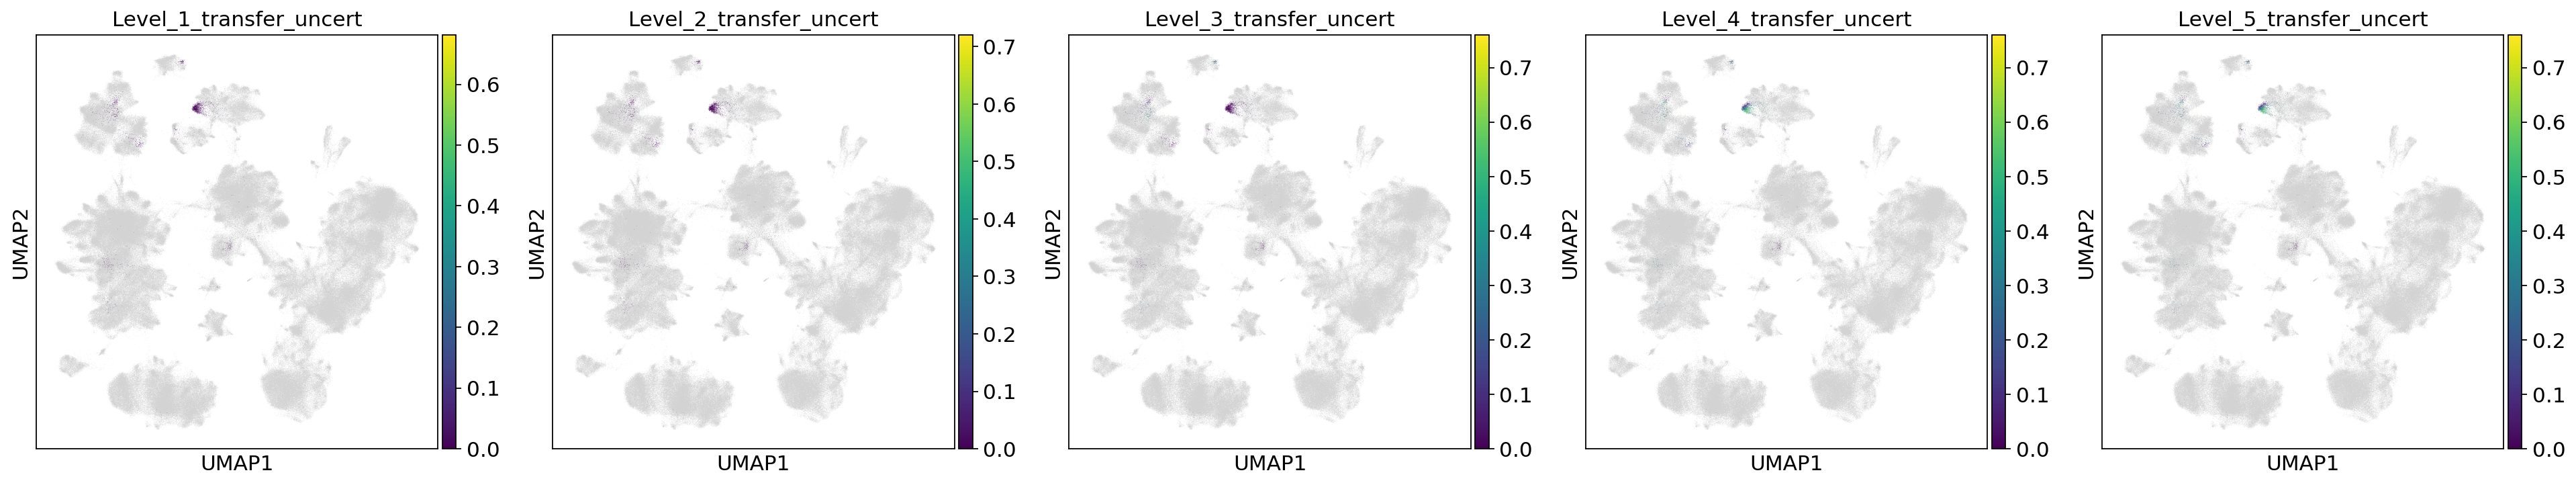

In [85]:
sc.pl.umap(combined_emb,color=[f"Level_{lev}_transfer_uncert" for lev in range(1,6)],ncols=5)

Now let's take a look at the transfered labels, at every level. Note that the color for "Unknown" switches per plot.

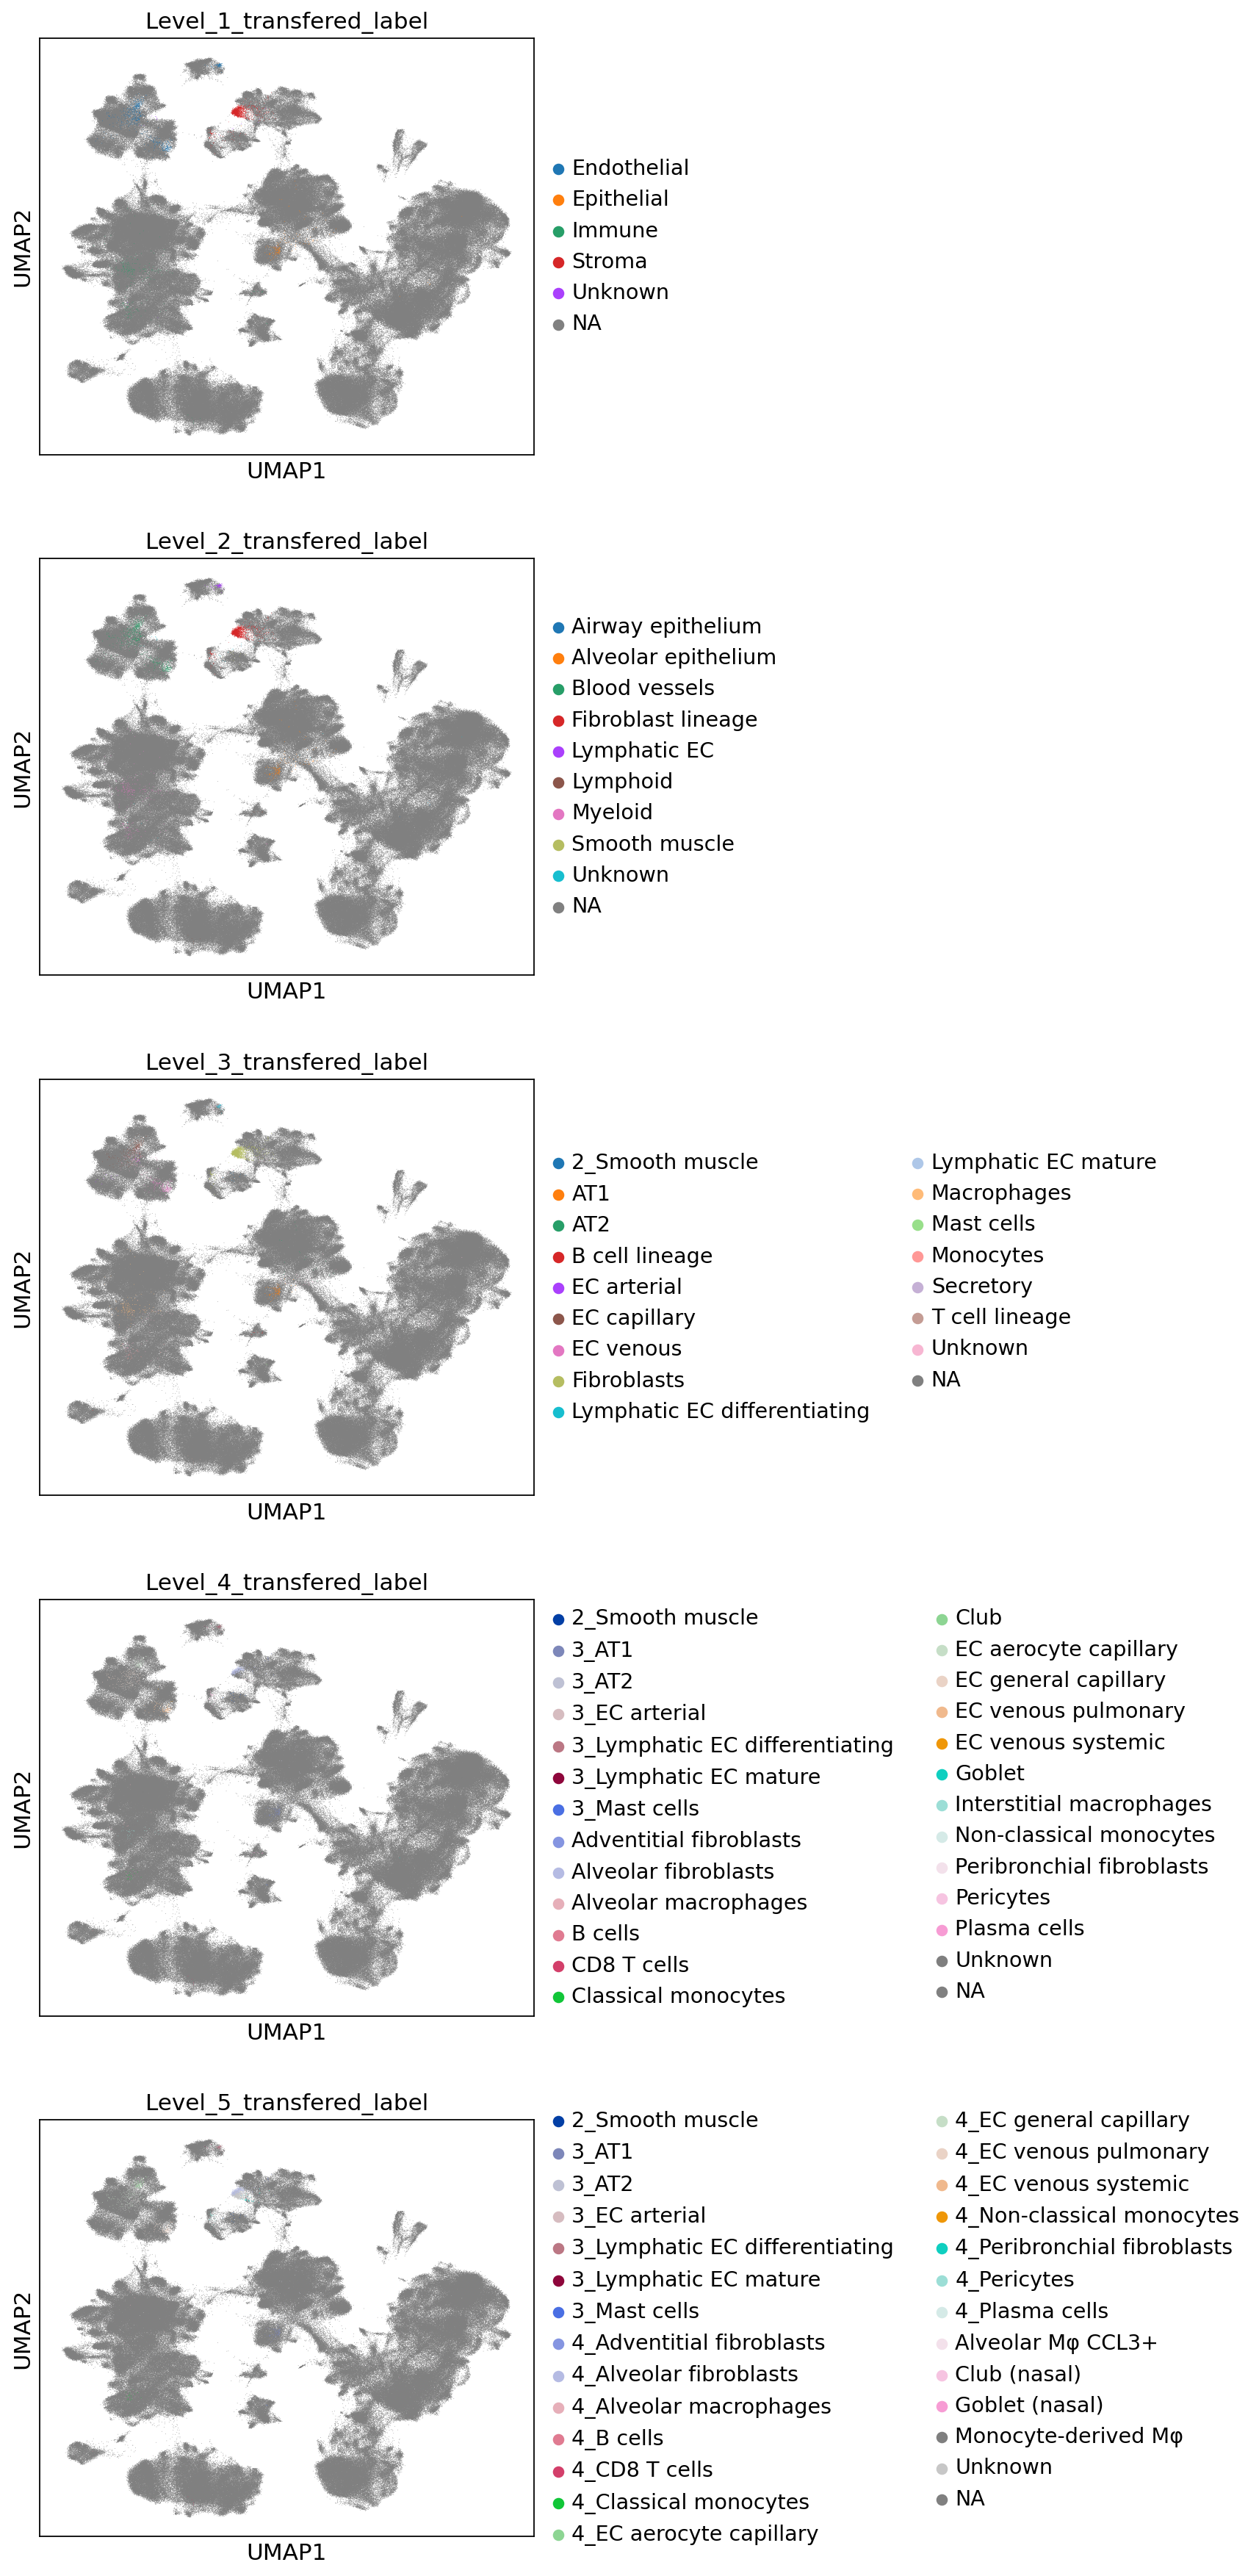

In [86]:
sc.pl.umap(combined_emb,color=[f"Level_{lev}_transfered_label" for lev in range(1,6)],na_color="grey",ncols=1,size=0.5)

For your reference, these are the annotations of the reference atlas:

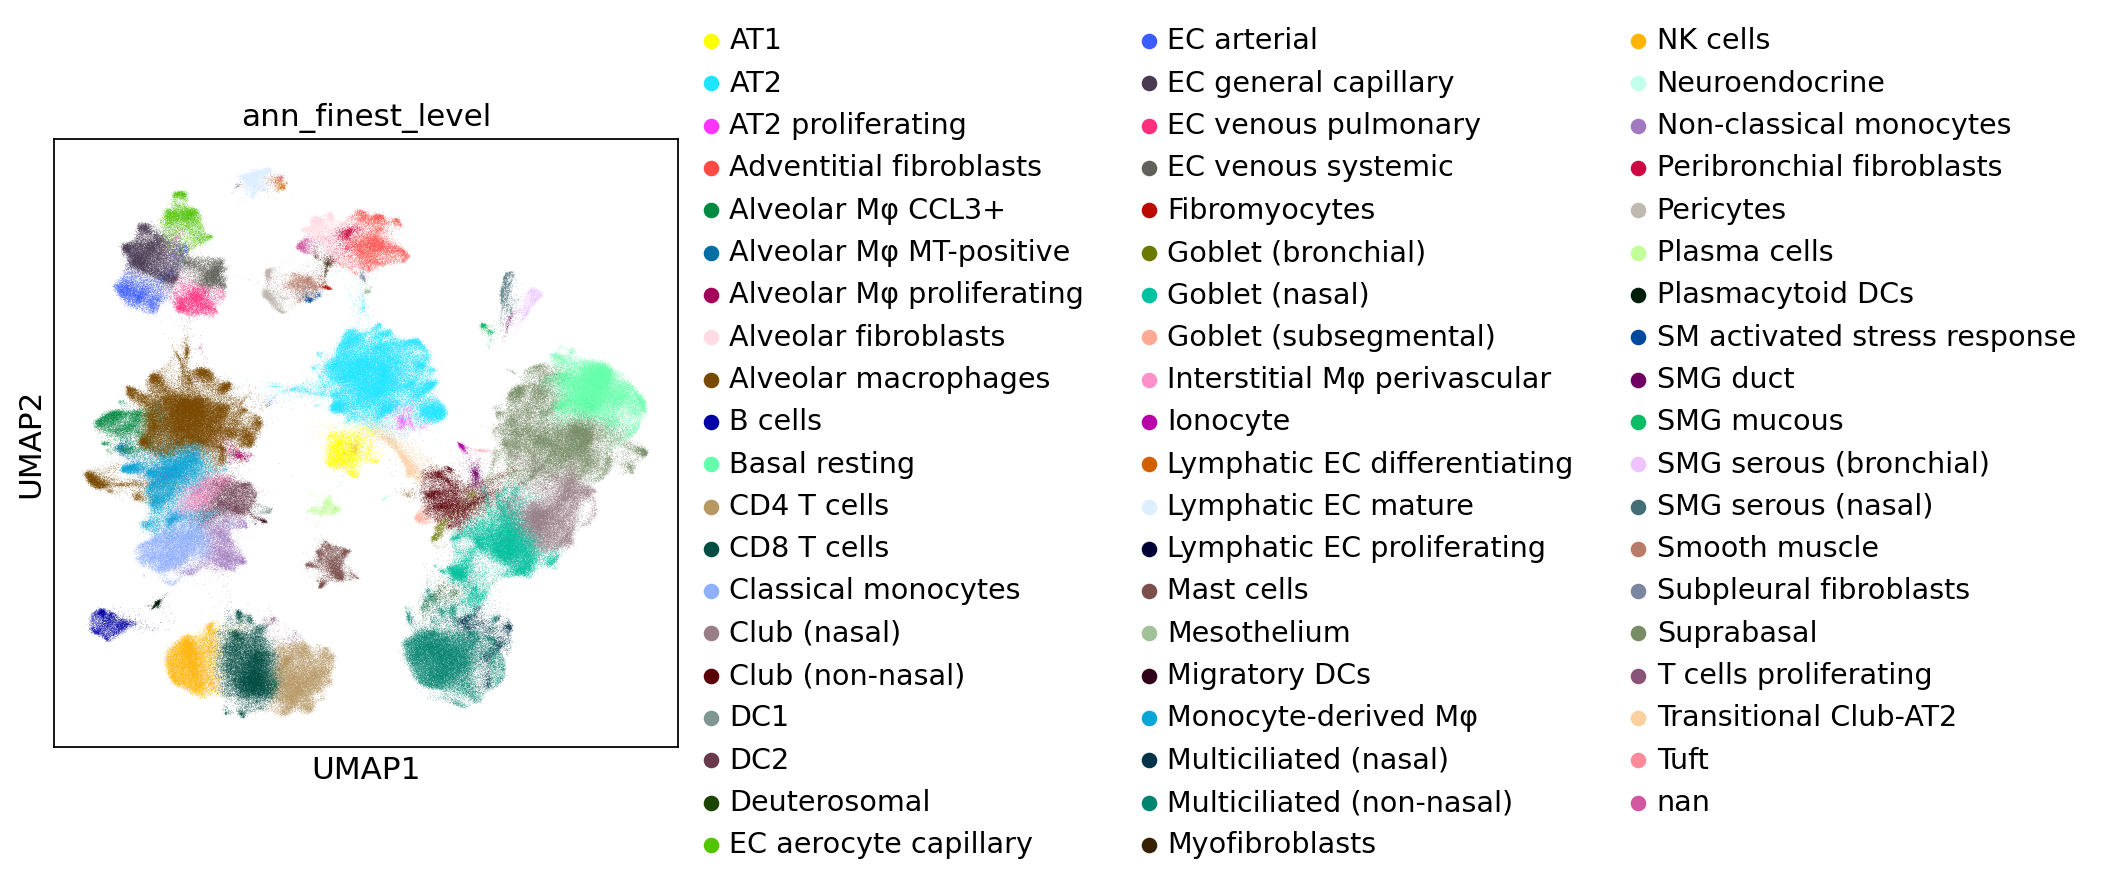

In [87]:
sc.pl.umap(combined_emb, color="ann_finest_level")